In [2]:
from typing import *
import torch
from torch import nn
from torchtyping import TensorType, patch_typeguard
from transformer import Transformer
import numpy as np
import matplotlib.pyplot as plt
from permutation import Permutation
from dataclasses import dataclass, field

%load_ext autoreload
%autoreload 2

patch_typeguard()

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device used : {device}')

Device used : cuda:0


# Dataset

In [4]:
def create_dataset(operator: Callable[[int, int], int], group_size: int, y_zero=True):
    """
    Create a complete dataset for the given operator on a group of the given size.
    """
    y_start = 0 if y_zero else 1
    data = {
        (x, y): operator(x, y) 
        for x in range(group_size) 
        for y in range(y_start, group_size)
    }
    
    inputs = torch.tensor(list(data.keys())).to(device)
    outputs = torch.tensor(list(data.values())).to(device)

    return inputs, outputs

class BinaryOperator:
    def __init__(self, op):
        self.op     = np.vectorize(op)
        
    def apply(self, x, y):
        return self.op(x, y)

composition = BinaryOperator(lambda x, y: x * y)

def get_lehmer(n):
    return np.vectorize(lambda perm: perm.lehmer(n))

def create_dataset_v2(op: BinaryOperator, x, y, p):
    xv, yv = np.meshgrid(x, y)
    
    numeric_results = op.apply(xv, yv)
    
    lehmer_transform = get_lehmer(p)
    numeric_results = lehmer_transform(numeric_results)
    
    xv = lehmer_transform(xv)
    yv = lehmer_transform(yv)
        
    ds = np.dstack((xv, yv))
    ds_size = ds.size

    inputs  = torch.tensor(np.dstack((xv, yv)).reshape((ds_size//2, 2))).long().to(device)
    outputs = torch.tensor(numeric_results.reshape((ds_size//2))).long().to(device)
    return inputs, outputs 


In [5]:
@dataclass
class Dataset:
    train_x: TensorType["batch", "seq_len"]
    train_y: TensorType["batch", "seq_len"]
    test_x: TensorType["batch", "seq_len"]
    test_y: TensorType["batch", "seq_len"]

def split_dataset(data_x, data_y, prop: float = 0.8) -> Dataset:
    """
    Split the given dataset into training and test sets.
    """
    order = torch.randperm(data_x.shape[0])
    train_size = int(prop * data_x.shape[0])

    return Dataset(
        train_x = data_x[order[:train_size]],
        train_y = data_y[order[:train_size]],
        test_x = data_x[order[train_size:]],
        test_y = data_y[order[train_size:]],
    )

# Training

In [6]:
@dataclass
class TrainingLog:
    train_losses: list[float] = field(default_factory=list)
    test_losses: list[float] = field(default_factory=list)
    train_acc: list[float] = field(default_factory=list)
    test_acc: list[float] = field(default_factory=list)
    epochs: list[float] = field(default_factory=list)

    def plot(self):
        # Two plots, one for loss, one for accuracy
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.set_xscale("log")
        ax1.plot(self.epochs, self.train_losses, label="training")
        ax1.plot(self.epochs, self.test_losses, label="test")
        ax1.title.set_text("Loss")
        ax1.legend()
        
        ax2.set_xscale("log")
        ax2.plot(self.epochs, self.train_acc, label="training")
        ax2.plot(self.epochs, self.test_acc, label="test")
        # line at acc = 1
        ax2.axhline(1, color="black", linestyle="--")
        ax2.title.set_text("Accuracy")
        ax2.legend()

In [7]:
def train(epochs, model, optimizer, data: Dataset, logs: TrainingLog):
    loss_fn = nn.CrossEntropyLoss()

    if logs.epochs:
        start_epoch = logs.epochs[-1] + 1
    else:
        start_epoch = 0

    for epoch in range(start_epoch, start_epoch + epochs):
        pred = model(data.train_x)
        loss = loss_fn(pred, data.train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 10 == 0:
            print(f'epoch : {epoch}')
            logs.epochs.append(epoch)
            logs.train_losses.append(loss.item())
            logs.train_acc.append((pred.argmax(dim=1) == data.train_y).float().mean().item())
            test_pred = model(data.test_x)
            logs.test_losses.append(loss_fn(test_pred, data.test_y).item())
            logs.test_acc.append((test_pred.argmax(dim=1) == data.test_y).float().mean().item())

# Experiments

In [8]:
group_size = 97
dmodel = 128
split = 0.5

epochs = 300
lr = 0.001
wd = 0.1

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.08836056292057037


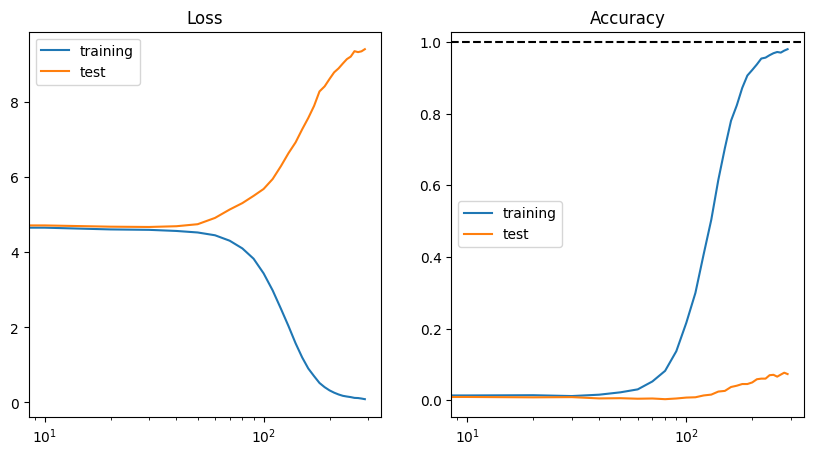

In [8]:
data_x, data_y = create_dataset(lambda x, y: (x + y) % group_size, group_size)
data_add = split_dataset(data_x, data_y, split)

model_add = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_add = torch.optim.AdamW(model_add.parameters(), lr=lr, weight_decay=wd)

logs_add = TrainingLog()
train(epochs, model_add, optimizer_add, data_add, logs_add)
print(f"Final train loss: {logs_add.train_losses[-1]}")
logs_add.plot()

epoch : 300
epoch : 310
epoch : 320
epoch : 330
epoch : 340
epoch : 350
epoch : 360
epoch : 370
epoch : 380
epoch : 390
epoch : 400
epoch : 410
epoch : 420
epoch : 430
epoch : 440
epoch : 450
epoch : 460
epoch : 470
epoch : 480
epoch : 490
epoch : 500
epoch : 510
epoch : 520
epoch : 530
epoch : 540
epoch : 550
epoch : 560
epoch : 570
epoch : 580
epoch : 590
epoch : 600
epoch : 610
epoch : 620
epoch : 630
epoch : 640
epoch : 650
epoch : 660
epoch : 670
epoch : 680
epoch : 690
epoch : 700
epoch : 710
epoch : 720
epoch : 730
epoch : 740
epoch : 750
epoch : 760
epoch : 770
epoch : 780
epoch : 790
epoch : 800
epoch : 810
epoch : 820
epoch : 830
epoch : 840
epoch : 850
epoch : 860
epoch : 870
epoch : 880
epoch : 890
epoch : 900
epoch : 910
epoch : 920
epoch : 930
epoch : 940
epoch : 950
epoch : 960
epoch : 970
epoch : 980
epoch : 990
epoch : 1000
epoch : 1010
epoch : 1020
epoch : 1030
epoch : 1040
epoch : 1050
epoch : 1060
epoch : 1070
epoch : 1080
epoch : 1090
epoch : 1100
epoch : 1110
epoc

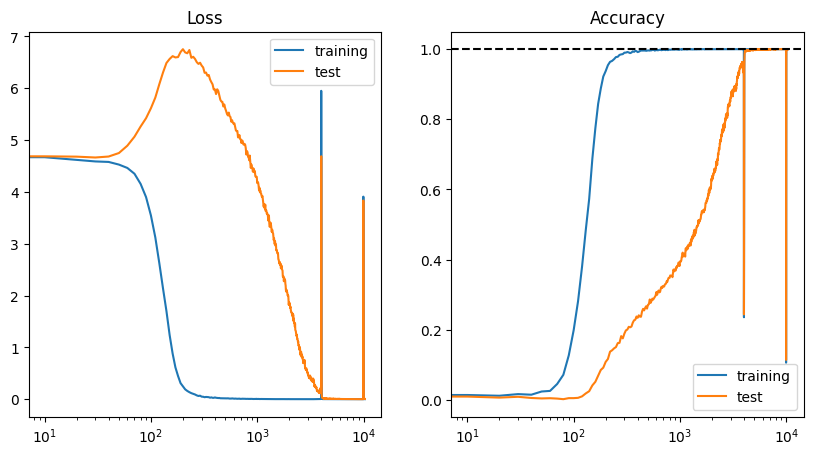

In [9]:
# Re-run this as many times as desired to continue training
train(10000, model_add, optimizer_add, data_add, logs_add)
logs_add.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.16151760518550873


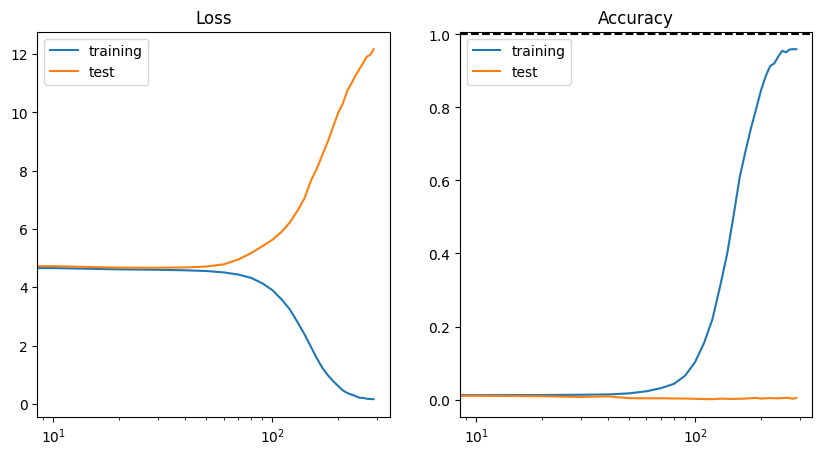

In [10]:
data_x, data_y = create_dataset(lambda x, y: (x - y) % group_size, group_size)
data_sub = split_dataset(data_x, data_y, split)

model_sub = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_sub = torch.optim.AdamW(model_sub.parameters(), lr=lr, weight_decay=wd)

logs_sub = TrainingLog()
train(epochs, model_sub, optimizer_sub, data_sub, logs_sub)
print(f"Final train loss: {logs_sub.train_losses[-1]}")
logs_sub.plot()

epoch : 300
epoch : 310
epoch : 320
epoch : 330
epoch : 340
epoch : 350
epoch : 360
epoch : 370
epoch : 380
epoch : 390
epoch : 400
epoch : 410
epoch : 420
epoch : 430
epoch : 440
epoch : 450
epoch : 460
epoch : 470
epoch : 480
epoch : 490
epoch : 500
epoch : 510
epoch : 520
epoch : 530
epoch : 540
epoch : 550
epoch : 560
epoch : 570
epoch : 580
epoch : 590
epoch : 600
epoch : 610
epoch : 620
epoch : 630
epoch : 640
epoch : 650
epoch : 660
epoch : 670
epoch : 680
epoch : 690
epoch : 700
epoch : 710
epoch : 720
epoch : 730
epoch : 740
epoch : 750
epoch : 760
epoch : 770
epoch : 780
epoch : 790
epoch : 800
epoch : 810
epoch : 820
epoch : 830
epoch : 840
epoch : 850
epoch : 860
epoch : 870
epoch : 880
epoch : 890
epoch : 900
epoch : 910
epoch : 920
epoch : 930
epoch : 940
epoch : 950
epoch : 960
epoch : 970
epoch : 980
epoch : 990
epoch : 1000
epoch : 1010
epoch : 1020
epoch : 1030
epoch : 1040
epoch : 1050
epoch : 1060
epoch : 1070
epoch : 1080
epoch : 1090
epoch : 1100
epoch : 1110
epoc

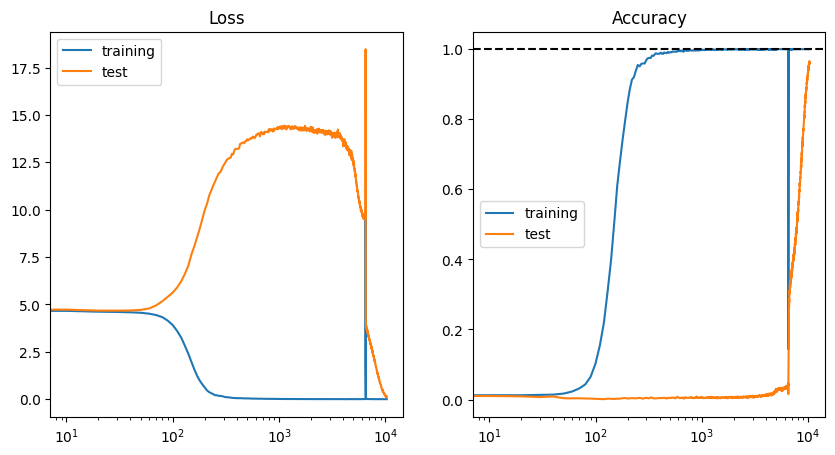

In [11]:
# Re-run this as many times as desired to continue training
train(10000, model_sub, optimizer_sub, data_sub, logs_sub)
logs_sub.plot()

In [23]:
data_x, data_y = create_dataset(lambda x, y: (x*x + y*y) % group_size, group_size)
data_sum_squares = split_dataset(data_x, data_y, split)

model_sum_squares = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_sum_squares = torch.optim.AdamW(model_sum_squares.parameters(), lr=lr, weight_decay=wd)

logs_sum_squares = TrainingLog()
train(epochs, model_sum_squares, optimizer_sum_squares, data_sum_squares, logs_sum_squares)
print(f"Final train loss: {logs_sum_squares.train_losses[-1]}")
logs_sum_squares.plot()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

epoch : 300
epoch : 310
epoch : 320
epoch : 330
epoch : 340
epoch : 350
epoch : 360
epoch : 370
epoch : 380
epoch : 390
epoch : 400
epoch : 410
epoch : 420
epoch : 430
epoch : 440
epoch : 450
epoch : 460
epoch : 470
epoch : 480
epoch : 490
epoch : 500
epoch : 510
epoch : 520
epoch : 530
epoch : 540
epoch : 550
epoch : 560
epoch : 570
epoch : 580
epoch : 590
epoch : 600
epoch : 610
epoch : 620
epoch : 630
epoch : 640
epoch : 650
epoch : 660
epoch : 670
epoch : 680
epoch : 690
epoch : 700
epoch : 710
epoch : 720
epoch : 730
epoch : 740
epoch : 750
epoch : 760
epoch : 770
epoch : 780
epoch : 790
epoch : 800
epoch : 810
epoch : 820
epoch : 830
epoch : 840
epoch : 850
epoch : 860
epoch : 870
epoch : 880
epoch : 890
epoch : 900
epoch : 910
epoch : 920
epoch : 930
epoch : 940
epoch : 950
epoch : 960
epoch : 970
epoch : 980
epoch : 990
epoch : 1000
epoch : 1010
epoch : 1020
epoch : 1030
epoch : 1040
epoch : 1050
epoch : 1060
epoch : 1070
epoch : 1080
epoch : 1090
epoch : 1100
epoch : 1110
epoc

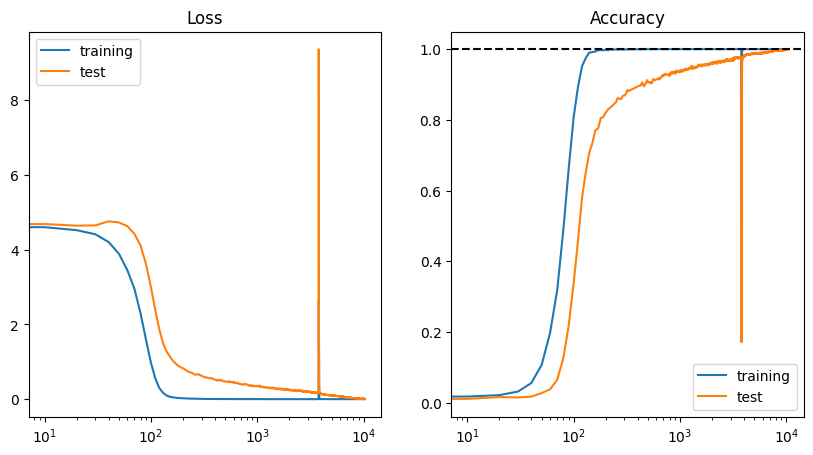

In [13]:
# Re-run this as many times as desired to continue training
train(10000, model_sum_squares, optimizer_sum_squares, data_sum_squares, logs_sum_squares)
logs_sum_squares.plot()

In [22]:
data_x, data_y = create_dataset(lambda x, y: (x * pow(y, -1, group_size)) % group_size, group_size, y_zero=False)
data_div = split_dataset(data_x, data_y, split)

model_div = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_div = torch.optim.AdamW(model_div.parameters(), lr=lr, weight_decay=wd)

logs_div = TrainingLog()
train(epochs, model_div, optimizer_div, data_div, logs_div)
print(f"Final train loss: {logs_div.train_losses[-1]}")
logs_div.plot()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

epoch : 300
epoch : 310
epoch : 320
epoch : 330
epoch : 340
epoch : 350
epoch : 360
epoch : 370
epoch : 380
epoch : 390
epoch : 400
epoch : 410
epoch : 420
epoch : 430
epoch : 440
epoch : 450
epoch : 460
epoch : 470
epoch : 480
epoch : 490
epoch : 500
epoch : 510
epoch : 520
epoch : 530
epoch : 540
epoch : 550
epoch : 560
epoch : 570
epoch : 580
epoch : 590
epoch : 600
epoch : 610
epoch : 620
epoch : 630
epoch : 640
epoch : 650
epoch : 660
epoch : 670
epoch : 680
epoch : 690
epoch : 700
epoch : 710
epoch : 720
epoch : 730
epoch : 740
epoch : 750
epoch : 760
epoch : 770
epoch : 780
epoch : 790
epoch : 800
epoch : 810
epoch : 820
epoch : 830
epoch : 840
epoch : 850
epoch : 860
epoch : 870
epoch : 880
epoch : 890
epoch : 900
epoch : 910
epoch : 920
epoch : 930
epoch : 940
epoch : 950
epoch : 960
epoch : 970
epoch : 980
epoch : 990
epoch : 1000
epoch : 1010
epoch : 1020
epoch : 1030
epoch : 1040
epoch : 1050
epoch : 1060
epoch : 1070
epoch : 1080
epoch : 1090
epoch : 1100
epoch : 1110
epoc

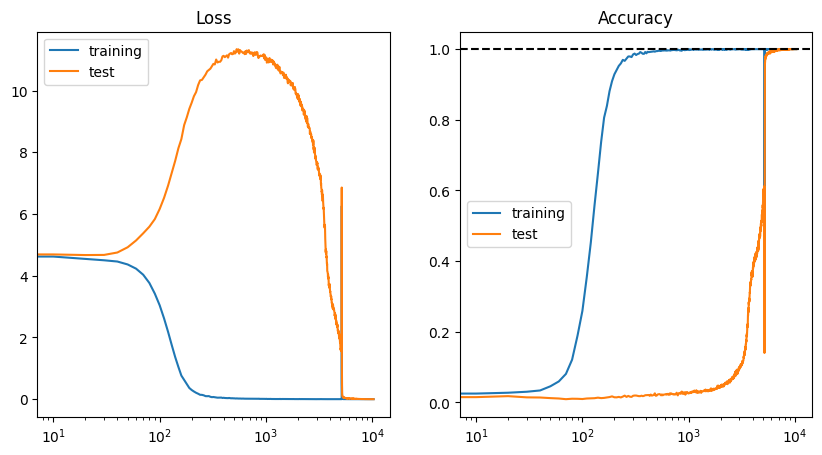

In [15]:
# Re-run this as many times as desired to continue training
train(10000, model_div, optimizer_div, data_div, logs_div)
logs_div.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.12805844843387604


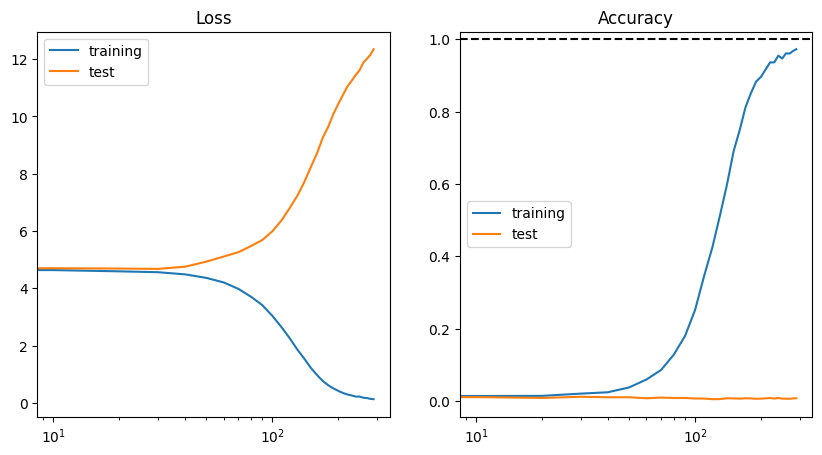

In [13]:
data_x, data_y = create_dataset(lambda x, y: ((x * pow(y, -1, group_size)) % group_size) if (y % 2) == 1 else ((x - y) % group_size), group_size, y_zero=True)
data_div_odd_even = split_dataset(data_x, data_y, split)

model_div_odd_even = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_div_odd_even = torch.optim.AdamW(model_div_odd_even.parameters(), lr=lr, weight_decay=wd)

logs_div_odd_even = TrainingLog()
train(epochs, model_div_odd_even, optimizer_div_odd_even, data_div_odd_even, logs_div_odd_even)
print(f"Final train loss: {logs_div_odd_even.train_losses[-1]}")
logs_div_odd_even.plot()

epoch : 300
epoch : 310
epoch : 320
epoch : 330
epoch : 340
epoch : 350
epoch : 360
epoch : 370
epoch : 380
epoch : 390
epoch : 400
epoch : 410
epoch : 420
epoch : 430
epoch : 440
epoch : 450
epoch : 460
epoch : 470
epoch : 480
epoch : 490
epoch : 500
epoch : 510
epoch : 520
epoch : 530
epoch : 540
epoch : 550
epoch : 560
epoch : 570
epoch : 580
epoch : 590
epoch : 600
epoch : 610
epoch : 620
epoch : 630
epoch : 640
epoch : 650
epoch : 660
epoch : 670
epoch : 680
epoch : 690
epoch : 700
epoch : 710
epoch : 720
epoch : 730
epoch : 740
epoch : 750
epoch : 760
epoch : 770
epoch : 780
epoch : 790
epoch : 800
epoch : 810
epoch : 820
epoch : 830
epoch : 840
epoch : 850
epoch : 860
epoch : 870
epoch : 880
epoch : 890
epoch : 900
epoch : 910
epoch : 920
epoch : 930
epoch : 940
epoch : 950
epoch : 960
epoch : 970
epoch : 980
epoch : 990
epoch : 1000
epoch : 1010
epoch : 1020
epoch : 1030
epoch : 1040
epoch : 1050
epoch : 1060
epoch : 1070
epoch : 1080
epoch : 1090
epoch : 1100
epoch : 1110
epoc

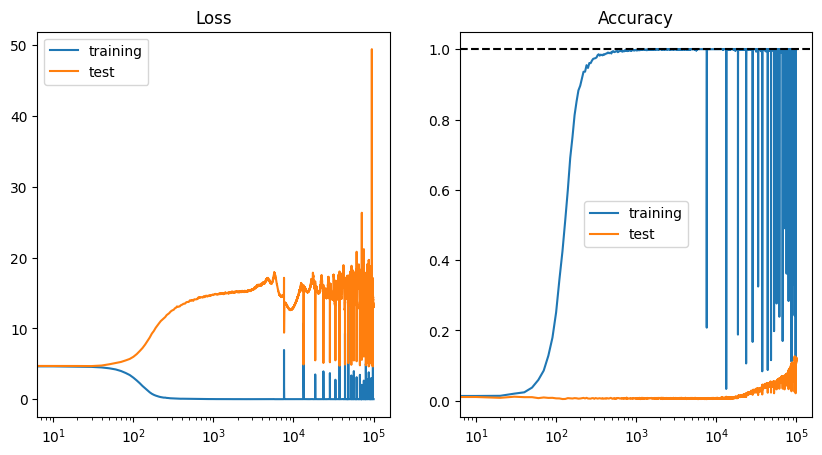

In [14]:
# Re-run this as many times as desired to continue training
train(100000, model_div_odd_even, optimizer_div_odd_even, data_div_odd_even, logs_div_odd_even)
logs_div_odd_even.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.09901480376720428


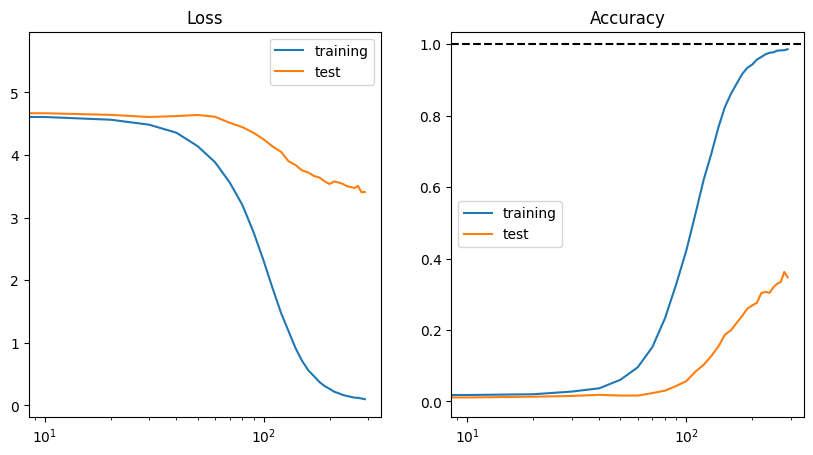

In [14]:
data_x, data_y = create_dataset(lambda x, y: (x*x + x*y + y*y) % group_size, group_size, y_zero=True)
data_sum_squares_xy = split_dataset(data_x, data_y, split)

model_sum_squares_xy = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_sum_squares_xy = torch.optim.AdamW(model_sum_squares_xy.parameters(), lr=lr, weight_decay=wd)

logs_sum_squares_xy = TrainingLog()
train(epochs, model_sum_squares_xy, optimizer_sum_squares_xy, data_sum_squares_xy, logs_sum_squares_xy)
print(f"Final train loss: {logs_sum_squares_xy.train_losses[-1]}")
logs_sum_squares_xy.plot()

epoch : 2300
epoch : 2310
epoch : 2320
epoch : 2330
epoch : 2340
epoch : 2350
epoch : 2360
epoch : 2370
epoch : 2380
epoch : 2390
epoch : 2400
epoch : 2410
epoch : 2420
epoch : 2430
epoch : 2440
epoch : 2450
epoch : 2460
epoch : 2470
epoch : 2480
epoch : 2490
epoch : 2500
epoch : 2510
epoch : 2520
epoch : 2530
epoch : 2540
epoch : 2550
epoch : 2560
epoch : 2570
epoch : 2580
epoch : 2590
epoch : 2600
epoch : 2610
epoch : 2620
epoch : 2630
epoch : 2640
epoch : 2650
epoch : 2660
epoch : 2670
epoch : 2680
epoch : 2690
epoch : 2700
epoch : 2710
epoch : 2720
epoch : 2730
epoch : 2740
epoch : 2750
epoch : 2760
epoch : 2770
epoch : 2780
epoch : 2790
epoch : 2800
epoch : 2810
epoch : 2820
epoch : 2830
epoch : 2840
epoch : 2850
epoch : 2860
epoch : 2870
epoch : 2880
epoch : 2890
epoch : 2900
epoch : 2910
epoch : 2920
epoch : 2930
epoch : 2940
epoch : 2950
epoch : 2960
epoch : 2970
epoch : 2980
epoch : 2990
epoch : 3000
epoch : 3010
epoch : 3020
epoch : 3030
epoch : 3040
epoch : 3050
epoch : 3060

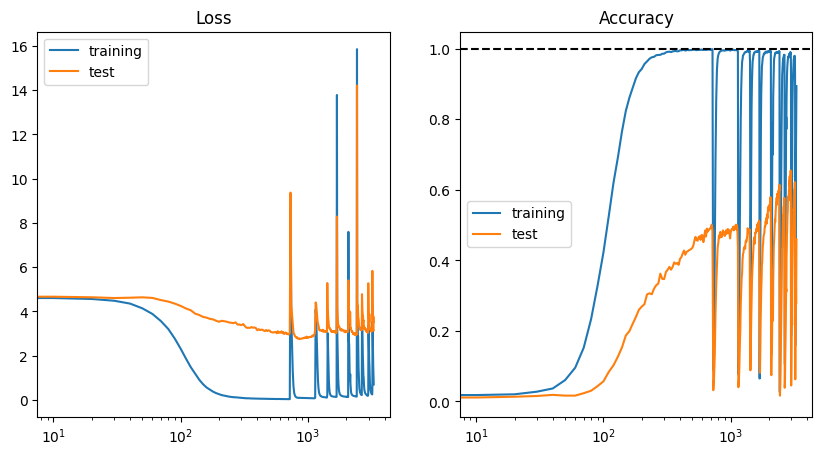

In [17]:
# Re-run this as many times as desired to continue training
train(1000, model_sum_squares_xy, optimizer_sum_squares_xy, data_sum_squares_xy, logs_sum_squares_xy)
logs_sum_squares_xy.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.12540487945079803


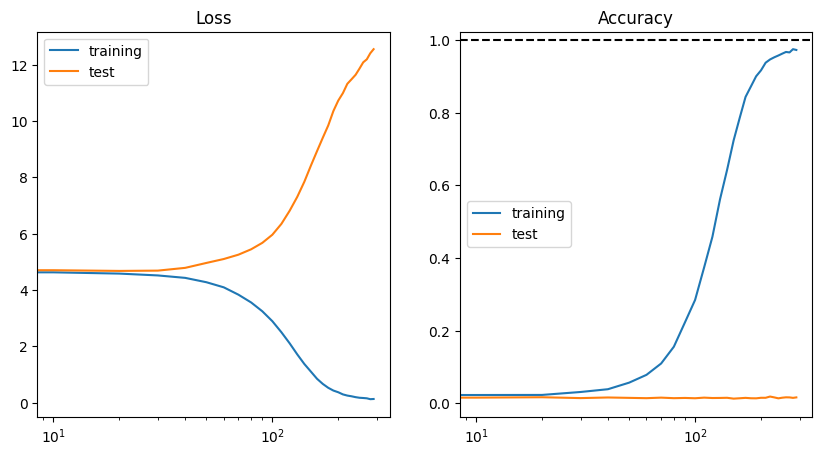

In [13]:
data_x, data_y = create_dataset(lambda x, y: (x*x*x + x*y) % group_size, group_size, y_zero=True)
data_x_cube_xy = split_dataset(data_x, data_y, split)

model_x_cube_xy = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_x_cube_xy = torch.optim.AdamW(model_x_cube_xy.parameters(), lr=lr, weight_decay=wd)

logs_x_cube_xy = TrainingLog()
train(epochs, model_x_cube_xy, optimizer_x_cube_xy, data_x_cube_xy, logs_x_cube_xy)
print(f"Final train loss: {logs_x_cube_xy.train_losses[-1]}")
logs_x_cube_xy.plot()

epoch : 20300
epoch : 20310
epoch : 20320
epoch : 20330
epoch : 20340
epoch : 20350
epoch : 20360
epoch : 20370
epoch : 20380
epoch : 20390
epoch : 20400
epoch : 20410
epoch : 20420
epoch : 20430
epoch : 20440
epoch : 20450
epoch : 20460
epoch : 20470
epoch : 20480
epoch : 20490
epoch : 20500
epoch : 20510
epoch : 20520
epoch : 20530
epoch : 20540
epoch : 20550
epoch : 20560
epoch : 20570
epoch : 20580
epoch : 20590
epoch : 20600
epoch : 20610
epoch : 20620
epoch : 20630
epoch : 20640
epoch : 20650
epoch : 20660
epoch : 20670
epoch : 20680
epoch : 20690
epoch : 20700
epoch : 20710
epoch : 20720
epoch : 20730
epoch : 20740
epoch : 20750
epoch : 20760
epoch : 20770
epoch : 20780
epoch : 20790
epoch : 20800
epoch : 20810
epoch : 20820
epoch : 20830
epoch : 20840
epoch : 20850
epoch : 20860
epoch : 20870
epoch : 20880
epoch : 20890
epoch : 20900
epoch : 20910
epoch : 20920
epoch : 20930
epoch : 20940
epoch : 20950
epoch : 20960
epoch : 20970
epoch : 20980
epoch : 20990
epoch : 21000
epoch 

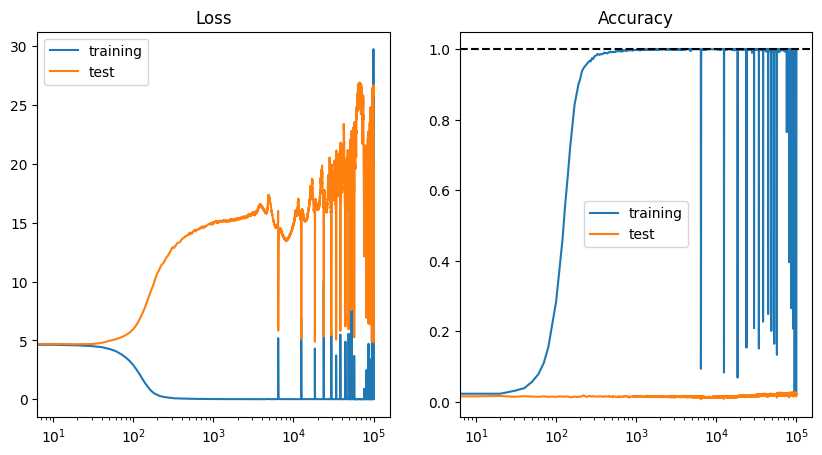

In [16]:
# Re-run this as many times as desired to continue training
train(100000, model_x_cube_xy, optimizer_x_cube_xy, data_x_cube_xy, logs_x_cube_xy)
logs_x_cube_xy.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.12540487945079803


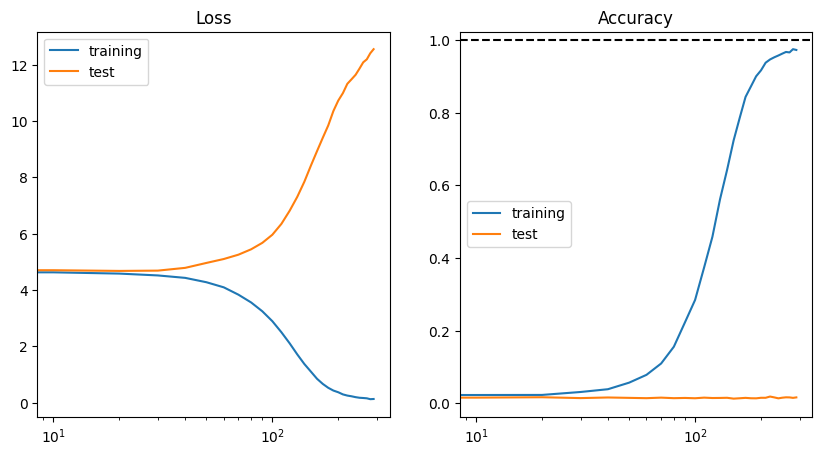

In [ ]:
data_x, data_y = create_dataset(lambda x, y: (x*x + x*y + y*y + x) % group_size, group_size, y_zero=True)
data_sum_squares_xy_x = split_dataset(data_x, data_y, split)

model_sum_squares_xy_x = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_sum_squares_xy_x = torch.optim.AdamW(model_sum_squares_xy_x.parameters(), lr=lr, weight_decay=wd)

logs_sum_squares_xy_x = TrainingLog()
train(epochs, model_sum_squares_xy_x, optimizer_sum_squares_xy_x, data_sum_squares_xy_x, logs_sum_squares_xy_x)
print(f"Final train loss: {logs_sum_squares_xy_x.train_losses[-1]}")
logs_sum_squares_xy_x.plot()

epoch : 20300
epoch : 20310
epoch : 20320
epoch : 20330
epoch : 20340
epoch : 20350
epoch : 20360
epoch : 20370
epoch : 20380
epoch : 20390
epoch : 20400
epoch : 20410
epoch : 20420
epoch : 20430
epoch : 20440
epoch : 20450
epoch : 20460
epoch : 20470
epoch : 20480
epoch : 20490
epoch : 20500
epoch : 20510
epoch : 20520
epoch : 20530
epoch : 20540
epoch : 20550
epoch : 20560
epoch : 20570
epoch : 20580
epoch : 20590
epoch : 20600
epoch : 20610
epoch : 20620
epoch : 20630
epoch : 20640
epoch : 20650
epoch : 20660
epoch : 20670
epoch : 20680
epoch : 20690
epoch : 20700
epoch : 20710
epoch : 20720
epoch : 20730
epoch : 20740
epoch : 20750
epoch : 20760
epoch : 20770
epoch : 20780
epoch : 20790
epoch : 20800
epoch : 20810
epoch : 20820
epoch : 20830
epoch : 20840
epoch : 20850
epoch : 20860
epoch : 20870
epoch : 20880
epoch : 20890
epoch : 20900
epoch : 20910
epoch : 20920
epoch : 20930
epoch : 20940
epoch : 20950
epoch : 20960
epoch : 20970
epoch : 20980
epoch : 20990
epoch : 21000
epoch 

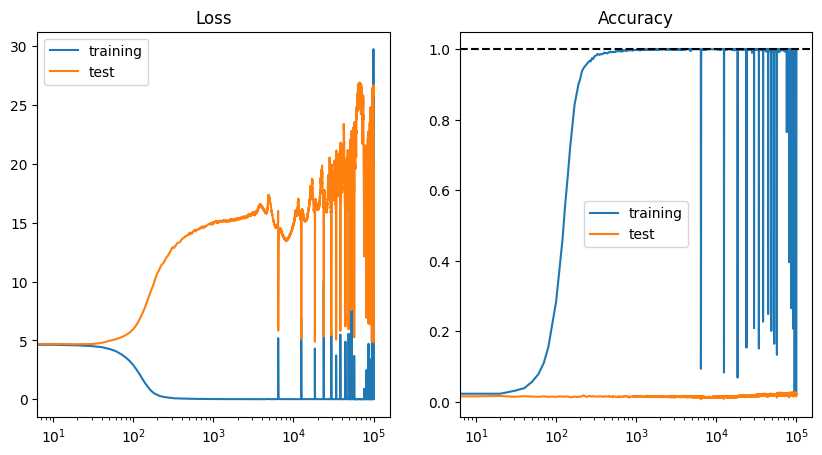

In [ ]:
# Re-run this as many times as desired to continue training
train(100000, model_sum_squares_xy_x, optimizer_sum_squares_xy_x, data_sum_squares_xy_x, logs_sum_squares_xy_x)
logs_sum_squares_xy_x.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.355710506439209


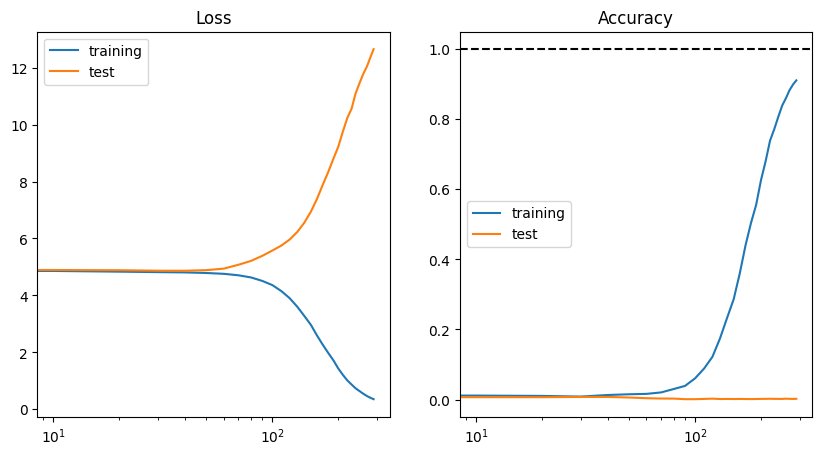

In [8]:
S5 = list(Permutation.group(5))
op = BinaryOperator(lambda x, y: x * y)
data_x, data_y = create_dataset_v2(op, S5, S5, p=5)
data_xy_s5 = split_dataset(data_x, data_y, split)

model_xy_s5 = Transformer(
    voc_size=120,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_xy_s5 = torch.optim.AdamW(model_xy_s5.parameters(), lr=lr, weight_decay=wd)

logs_xy_s5 = TrainingLog()
train(epochs, model_xy_s5, optimizer_xy_s5, data_xy_s5, logs_xy_s5)
print(f"Final train loss: {logs_xy_s5.train_losses[-1]}")
logs_xy_s5.plot()

epoch : 20300
epoch : 20310
epoch : 20320
epoch : 20330
epoch : 20340
epoch : 20350
epoch : 20360
epoch : 20370
epoch : 20380
epoch : 20390
epoch : 20400
epoch : 20410
epoch : 20420
epoch : 20430
epoch : 20440
epoch : 20450
epoch : 20460
epoch : 20470
epoch : 20480
epoch : 20490
epoch : 20500
epoch : 20510
epoch : 20520
epoch : 20530
epoch : 20540
epoch : 20550
epoch : 20560
epoch : 20570
epoch : 20580
epoch : 20590
epoch : 20600
epoch : 20610
epoch : 20620
epoch : 20630
epoch : 20640
epoch : 20650
epoch : 20660
epoch : 20670
epoch : 20680
epoch : 20690
epoch : 20700
epoch : 20710
epoch : 20720
epoch : 20730
epoch : 20740
epoch : 20750
epoch : 20760
epoch : 20770
epoch : 20780
epoch : 20790
epoch : 20800
epoch : 20810
epoch : 20820
epoch : 20830
epoch : 20840
epoch : 20850
epoch : 20860
epoch : 20870
epoch : 20880
epoch : 20890
epoch : 20900
epoch : 20910
epoch : 20920
epoch : 20930
epoch : 20940
epoch : 20950
epoch : 20960
epoch : 20970
epoch : 20980
epoch : 20990
epoch : 21000
epoch 

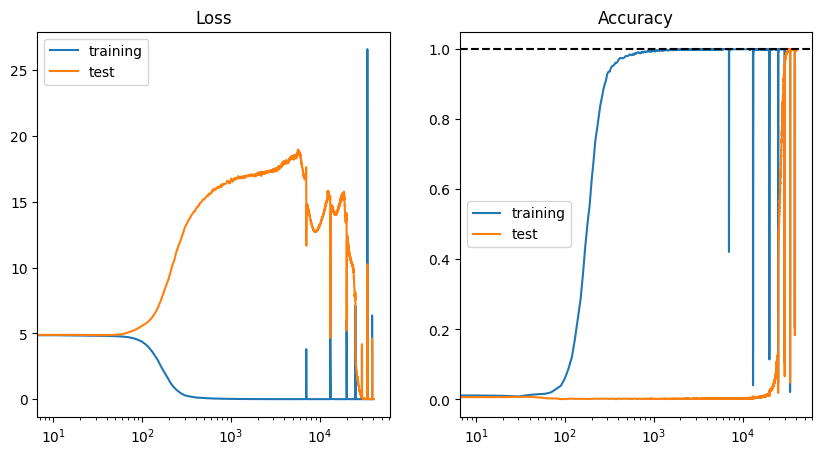

In [11]:
# Re-run this as many times as desired to continue training
train(100000, model_xy_s5, optimizer_xy_s5, data_xy_s5, logs_xy_s5)
logs_xy_s5.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.38370373845100403


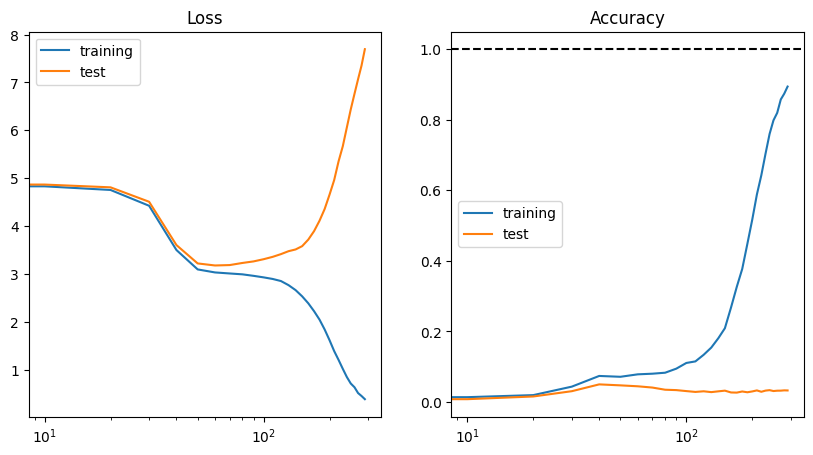

In [12]:
S5 = list(Permutation.group(5))
op = BinaryOperator(lambda x, y: x * y * x.inverse())
data_x, data_y = create_dataset_v2(op, S5, S5, p=5)
data_xyx_inverse_s5 = split_dataset(data_x, data_y, split)

model_xyx_inverse_s5 = Transformer(
    voc_size=120,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_xyx_inverse_s5 = torch.optim.AdamW(model_xyx_inverse_s5.parameters(), lr=lr, weight_decay=wd)

logs_xyx_inverse_s5 = TrainingLog()
train(epochs, model_xyx_inverse_s5, optimizer_xyx_inverse_s5, data_xyx_inverse_s5, logs_xyx_inverse_s5)
print(f"Final train loss: {logs_xyx_inverse_s5.train_losses[-1]}")
logs_xyx_inverse_s5.plot()

epoch : 300
epoch : 310
epoch : 320
epoch : 330
epoch : 340
epoch : 350
epoch : 360
epoch : 370
epoch : 380
epoch : 390
epoch : 400
epoch : 410
epoch : 420
epoch : 430
epoch : 440
epoch : 450
epoch : 460
epoch : 470
epoch : 480
epoch : 490
epoch : 500
epoch : 510
epoch : 520
epoch : 530
epoch : 540
epoch : 550
epoch : 560
epoch : 570
epoch : 580
epoch : 590
epoch : 600
epoch : 610
epoch : 620
epoch : 630
epoch : 640
epoch : 650
epoch : 660
epoch : 670
epoch : 680
epoch : 690
epoch : 700
epoch : 710
epoch : 720
epoch : 730
epoch : 740
epoch : 750
epoch : 760
epoch : 770
epoch : 780
epoch : 790
epoch : 800
epoch : 810
epoch : 820
epoch : 830
epoch : 840
epoch : 850
epoch : 860
epoch : 870
epoch : 880
epoch : 890
epoch : 900
epoch : 910
epoch : 920
epoch : 930
epoch : 940
epoch : 950
epoch : 960
epoch : 970
epoch : 980
epoch : 990
epoch : 1000
epoch : 1010
epoch : 1020
epoch : 1030
epoch : 1040
epoch : 1050
epoch : 1060
epoch : 1070
epoch : 1080
epoch : 1090
epoch : 1100
epoch : 1110
epoc

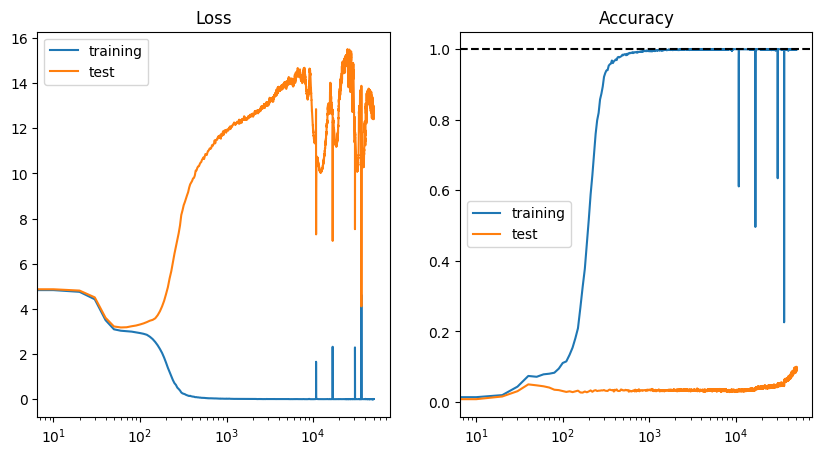

In [13]:
# Re-run this as many times as desired to continue training
train(100000, model_xyx_inverse_s5, optimizer_xyx_inverse_s5, data_xyx_inverse_s5, logs_xyx_inverse_s5)
logs_xyx_inverse_s5.plot()

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100
epoch : 110
epoch : 120
epoch : 130
epoch : 140
epoch : 150
epoch : 160
epoch : 170
epoch : 180
epoch : 190
epoch : 200
epoch : 210
epoch : 220
epoch : 230
epoch : 240
epoch : 250
epoch : 260
epoch : 270
epoch : 280
epoch : 290
Final train loss: 0.27092444896698


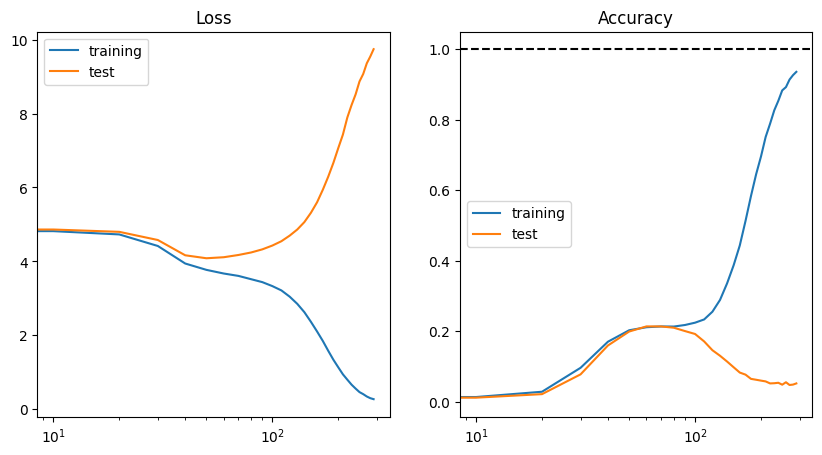

In [9]:
S5 = list(Permutation.group(5))
op = BinaryOperator(lambda x, y: x * y * x)
data_x, data_y = create_dataset_v2(op, S5, S5, p=5)
data_xyx_s5 = split_dataset(data_x, data_y, split)

model_xyx_s5 = Transformer(
    voc_size=120,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    mlp_dims=[4 * dmodel],
).to(device)
optimizer_xyx_s5 = torch.optim.AdamW(model_xyx_s5.parameters(), lr=lr, weight_decay=wd)

logs_xyx_s5 = TrainingLog()
train(epochs, model_xyx_s5, optimizer_xyx_s5, data_xyx_s5, logs_xyx_s5)
print(f"Final train loss: {logs_xyx_s5.train_losses[-1]}")
logs_xyx_s5.plot()

epoch : 300
epoch : 310
epoch : 320
epoch : 330
epoch : 340
epoch : 350
epoch : 360
epoch : 370
epoch : 380
epoch : 390
epoch : 400
epoch : 410
epoch : 420
epoch : 430
epoch : 440
epoch : 450
epoch : 460
epoch : 470
epoch : 480
epoch : 490
epoch : 500
epoch : 510
epoch : 520
epoch : 530
epoch : 540
epoch : 550
epoch : 560
epoch : 570
epoch : 580
epoch : 590
epoch : 600
epoch : 610
epoch : 620
epoch : 630
epoch : 640
epoch : 650
epoch : 660
epoch : 670
epoch : 680
epoch : 690
epoch : 700
epoch : 710
epoch : 720
epoch : 730
epoch : 740
epoch : 750
epoch : 760
epoch : 770
epoch : 780
epoch : 790
epoch : 800
epoch : 810
epoch : 820
epoch : 830
epoch : 840
epoch : 850
epoch : 860
epoch : 870
epoch : 880
epoch : 890
epoch : 900
epoch : 910
epoch : 920
epoch : 930
epoch : 940
epoch : 950
epoch : 960
epoch : 970
epoch : 980
epoch : 990
epoch : 1000
epoch : 1010
epoch : 1020
epoch : 1030
epoch : 1040
epoch : 1050
epoch : 1060
epoch : 1070
epoch : 1080
epoch : 1090
epoch : 1100
epoch : 1110
epoc

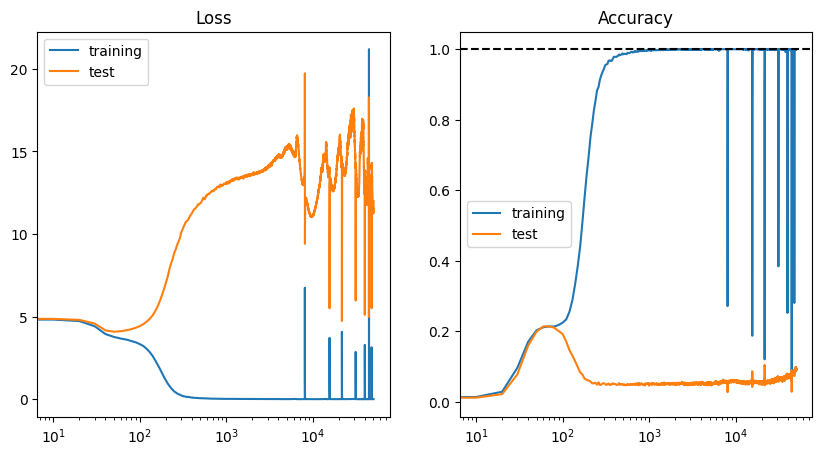

In [10]:
# Re-run this as many times as desired to continue training
train(100000, model_xyx_s5, optimizer_xyx_s5, data_xyx_s5, logs_xyx_s5)
logs_xyx_s5.plot()